<a href="https://colab.research.google.com/github/nathaliacastelobranco/infnet-analise-de-dados-pyspark/blob/main/01_EDA_An%C3%A1lise_de_dados_com_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de dados com PySpark []

Nathalia Castelo Branco

---
### Parte 1

1. Desenvolva um notebook bem documentado em Python utilizando a biblioteca PySpark para apresentar as análises realizadas no trabalho do Hadoop

- Para cada análise realizada, escreva a consulta em SQL no Spark e também utilize as funções vistas em aula
- Acrescente novas análises para uma análise exploratória mais detalhada
- Utilize funções de agregação (count, min, max, avg, sum, etc.)

O desenvolvimento deste trabalho é baseado em outra análise de dados desenvolvida em Hive (Disciplina Infraestrutura Hadoop).

- Link para Github do projeto Hadoop: https://github.com/nathaliacastelobranco/infnet-infraestrutura-hadoop

In [1]:
# ==============================================
# 0. Instalações
# ==============================================

!pip install pyspark

!pip install gcsfs pyarrow fastparquet -q

!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://repo1.maven.org/maven2/com/google/cloud/bigdataoss/gcs-connector/hadoop3-2.2.5/gcs-connector-hadoop3-2.2.5-shaded.jar -O gcs-connector.jar

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.7 MB/s eta 0:00:00


In [2]:
# ==============================================
# 1. Dependências, autenticação e configurações
# ==============================================
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, desc, col, max, when, isnan, substring, when, col, lit

import os
import shutil
import pyarrow as pa
import pyarrow.parquet as pq
from google.cloud import storage

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import pandas as pd

# Autenticação
from google.colab import auth
auth.authenticate_user()

In [3]:
sns.color_palette("rocket")

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

In [4]:
sns.set_palette("rocket")

In [5]:
# ========================================
# 2. Sessão Spark e Exploração dos dados
# ========================================
spark = SparkSession \
        .builder \
        .appName("CAGED-Spark") \
        .config("spark.jars", "gcs-connector.jar") \
        .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
        .getOrCreate()

## Leitura dos arquivos no Google Cloud Storage

### Fato CAGED

In [6]:
fato_caged = spark.read.parquet("gs://bucket_caged/caged_unificado/")
fato_caged.createOrReplaceTempView("fato_caged")
fato_caged.show(5, truncate=False)

+--------------+------+---+---------+-----+---------+-----------------+---------------+---------+---------------+-----+----------------+-------+----+--------------+-------------------+----------------+---------------+-------------------+--------------+--------+-----------+-----------------+--------------------+----------------------+--------------------+----------------+--------------+-------------------+-------+---------------+-------------+------------+-------+--------------+-----------------+
|competenciamov|regiao|uf |municipio|secao|subclasse|saldomovimentacao|cbo2002ocupacao|categoria|graudeinstrucao|idade|horascontratuais|racacor|sexo|tipoempregador|tipoestabelecimento|tipomovimentacao|tipodeficiencia|indtrabintermitente|indtrabparcial|salario |tamestabjan|indicadoraprendiz|origemdainformaÃ§Ã£o|indicadordeforadoprazo|unidadesalariocodigo|valorsalariofixo|competenciaexc|indicadordeexclusao|ano_mov|natureza_evento|impacto_saldo|faixa_etaria|ano_dec|competenciadec|origem_declaracao

### Dimensão UF

In [7]:
dim_uf = spark.read.csv("gs://bucket_caged/dimensoes/dim_uf/dim_uf.csv", header=False, inferSchema=True)
dim_uf = dim_uf.toDF("uf", "descricao_uf")
dim_uf.createOrReplaceTempView("dim_uf")
dim_uf.show()

+---+-------------------+
| uf|       descricao_uf|
+---+-------------------+
| 11|           Rondonia|
| 12|               Acre|
| 13|           Amazonas|
| 14|            Roraima|
| 15|               Para|
| 16|              Amapa|
| 17|          Tocantins|
| 21|           Maranhao|
| 22|              Piaui|
| 23|              Ceara|
| 24|Rio Grande do Norte|
| 25|            Paraiba|
| 26|         Pernambuco|
| 27|            Alagoas|
| 28|            Sergipe|
| 29|              Bahia|
| 31|       Minas Gerais|
| 32|     Espirito Santo|
| 33|     Rio de Janeiro|
| 35|          Sao Paulo|
+---+-------------------+
only showing top 20 rows



### Dimensão Região

In [8]:
dim_regiao = spark.read.csv("gs://bucket_caged/dimensoes/dim_regiao/dim_regiao.csv", header=False, inferSchema=True)
dim_regiao = dim_regiao.toDF("regiao", "descricao_regiao")
dim_regiao.createOrReplaceTempView("dim_regiao")
dim_regiao.show()

+------+----------------+
|regiao|descricao_regiao|
+------+----------------+
|     1|           Norte|
|     2|        Nordeste|
|     3|         Sudeste|
|     4|             Sul|
|     5|    Centro-Oeste|
|     9|Nao identificado|
+------+----------------+



### Dimensão Seção

In [9]:
dim_secao = spark.read.csv("gs://bucket_caged/dimensoes/dim_secao/dim_secao.csv", header=False, inferSchema=True, sep=";")
dim_secao = dim_secao.toDF("secao", "descricao_secao")
dim_secao.createOrReplaceTempView("dim_secao")
dim_secao.show()

+-----+--------------------+
|secao|     descricao_secao|
+-----+--------------------+
|    A|Agricultura, Pecu...|
|    B|Industrias Extrat...|
|    C|Industrias de Tra...|
|    D|  Eletricidade e Gas|
|    E|Agua, Esgoto, Ati...|
|    F|          Construcao|
|    G|Comercio, Reparac...|
|    H|Transporte, Armaz...|
|    I|Alojamento e Alim...|
|    J|Informacao e Comu...|
|    K|Atividades Financ...|
|    L|Atividades Imobil...|
|    M|Atividades Profis...|
|    N|Atividades Admini...|
|    O|Administracao Pub...|
|    P|            Educacao|
|    Q|Saude Humana e Se...|
|    R|Artes, Cultura, E...|
|    S|Outras Atividades...|
|    T| Servicos Domesticos|
+-----+--------------------+
only showing top 20 rows



### Dimensão Motivo de movimentação (admissão ou demissão)

In [10]:
dim_motivo = spark.read.csv("gs://bucket_caged/dimensoes/dim_motivo/dim_motivo.csv", header=False, inferSchema=True, sep=";")
dim_motivo = dim_motivo.toDF("tipomovimentacao", "descricao_motivo")
dim_motivo.createOrReplaceTempView("dim_motivo")
dim_motivo.show()

+----------------+--------------------+
|tipomovimentacao|    descricao_motivo|
+----------------+--------------------+
|              97|Admissao de Tipo ...|
|              25|Admissao por cont...|
|              10|Admissao por prim...|
|              20|Admissao por reem...|
|              35|Admissao por rein...|
|              70|Admissao por tran...|
|              33|     Culpa Reciproca|
|              40|Desligamento a pe...|
|              98|Desligamento de T...|
|              90|Desligamento por ...|
|              50|Desligamento por ...|
|              32|Desligamento por ...|
|              31|Desligamento por ...|
|              60|Desligamento por ...|
|              45|Desligamento por ...|
|              80|Desligamento por ...|
|              99|    Nao Identificado|
|              43|Termino contrato ...|
+----------------+--------------------+



### Dimensão Grau de instrução

In [11]:
dim_graudeinstrucao = spark.read.csv("gs://bucket_caged/dimensoes/dim_graudeinstrucao/dim_graudeinstrucao.csv", header=False, inferSchema=True, sep=";")
dim_graudeinstrucao = dim_graudeinstrucao.toDF("graudeinstrucao", "descricao_instrucao")
dim_graudeinstrucao.createOrReplaceTempView("dim_graudeinstrucao")
dim_graudeinstrucao.show()

+---------------+--------------------+
|graudeinstrucao| descricao_instrucao|
+---------------+--------------------+
|              1|          Analfabeto|
|              2|   Ate 5a Incompleto|
|              3|5a Completo Funda...|
|              4| 6a a 9a Fundamental|
|              5|Fundamental Completo|
|              6|    Medio Incompleto|
|              7|      Medio Completo|
|              8| Superior Incompleto|
|              9|   Superior Completo|
|             10|            Mestrado|
|             11|           Doutorado|
|             80|Pos-Graduacao Com...|
|             99|    Nao Identificado|
+---------------+--------------------+



### Dimensão CBO (Classificação Brasileira de Ocupações)

In [12]:
dim_cbo = spark.read.csv("gs://bucket_caged/dimensoes/dim_cbo/dim_cbo.csv", header=False, inferSchema=True, sep=";")
dim_cbo = dim_cbo.toDF("cbo", "descricao_cbo")
dim_cbo.createOrReplaceTempView("dim_cbo")
dim_cbo.show()

+-----+--------------------+
|  cbo|       descricao_cbo|
+-----+--------------------+
|10105|Oficial General d...|
|10110|Oficial General d...|
|10115|Oficial General d...|
|10205|Oficial da Aerona...|
|10210| Oficial do Exercito|
|10215|  Oficial da Marinha|
|10305|Praca da Aeronautica|
|10310|   Praca do Exercito|
|10315|    Praca da Marinha|
|20105|Coronel da Polici...|
|20110|Tenente-Coronel d...|
|20115|Major da Policia ...|
|20205|Capitao da Polici...|
|20305|Primeiro Tenente ...|
|20310|Segundo Tenente d...|
|21105|Subtenente da Pol...|
|21110|Sargento da Polic...|
|21205|Cabo da Policia M...|
|21210|Soldado da Polici...|
|30105|Coronel Bombeiro ...|
+-----+--------------------+
only showing top 20 rows



## Lista de todas as tabelas temporárias

In [13]:
spark.sql("SHOW TABLES").show()

+---------+-------------------+-----------+
|namespace|          tableName|isTemporary|
+---------+-------------------+-----------+
|         |            dim_cbo|       true|
|         |dim_graudeinstrucao|       true|
|         |         dim_motivo|       true|
|         |         dim_regiao|       true|
|         |          dim_secao|       true|
|         |             dim_uf|       true|
|         |         fato_caged|       true|
+---------+-------------------+-----------+



# Perguntas

## 1. Quantas admissões e desligamentos ocorreram em cada ano?

In [14]:
q1 = spark.sql(
"""SELECT
    f.ano_dec,
    m.descricao_motivo,
    COUNT(*) AS qtd_mov
FROM fato_caged f
LEFT JOIN dim_motivo m
    ON f.tipomovimentacao = m.tipomovimentacao
GROUP BY f.ano_dec, m.tipomovimentacao, m.descricao_motivo
ORDER BY f.ano_dec, qtd_mov DESC;""")

In [15]:
q1.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [ano_dec#33 ASC NULLS FIRST, qtd_mov#469L DESC NULLS LAST], true, 0
   +- Exchange rangepartitioning(ano_dec#33 ASC NULLS FIRST, qtd_mov#469L DESC NULLS LAST, 200), ENSURE_REQUIREMENTS, [plan_id=270]
      +- HashAggregate(keys=[ano_dec#33, tipomovimentacao#350, descricao_motivo#351], functions=[count(1)])
         +- Exchange hashpartitioning(ano_dec#33, tipomovimentacao#350, descricao_motivo#351, 200), ENSURE_REQUIREMENTS, [plan_id=267]
            +- HashAggregate(keys=[ano_dec#33, tipomovimentacao#350, descricao_motivo#351], functions=[partial_count(1)])
               +- Project [ano_dec#33, tipomovimentacao#350, descricao_motivo#351]
                  +- BroadcastHashJoin [tipomovimentacao#16L], [cast(tipomovimentacao#350 as bigint)], LeftOuter, BuildRight, false
                     :- Project [tipomovimentacao#16L, ano_dec#33]
                     :  +- FileScan parquet [tipomovimentacao#16L,ano_dec#33,competenciad

In [16]:
q1.show()

+-------+--------------------+--------+
|ano_dec|    descricao_motivo| qtd_mov|
+-------+--------------------+--------+
|   NULL|                NULL|      10|
|   NULL|Admissao de Tipo ...|       3|
|   NULL|Termino contrato ...|       1|
|   2020|Admissao por reem...|26503963|
|   2020|Desligamento por ...|16183592|
|   2020|Desligamento a pe...| 6765867|
|   2020|Termino contrato ...| 4311273|
|   2020|Admissao por prim...| 1934321|
|   2020|Desligamento por ...|  432908|
|   2020|Desligamento por ...|  361950|
|   2020|Desligamento por ...|  336268|
|   2020|Admissao por cont...|  140482|
|   2020|Desligamento por ...|  116744|
|   2020|     Culpa Reciproca|   40501|
|   2020|Admissao por rein...|   29080|
|   2020|Desligamento por ...|   26393|
|   2020|Desligamento de T...|    1251|
|   2021|Admissao por reem...| 6467287|
|   2021|Admissao de Tipo ...| 6076270|
|   2021|Desligamento por ...| 5643787|
+-------+--------------------+--------+
only showing top 20 rows



In [17]:
pandas_q1 = q1.toPandas()

In [18]:
pandas_q1.head()

,ano_dec,descricao_motivo,qtd_mov
0,NaN,None,10
1,NaN,Admissao de Tipo Ignorado,3
2,NaN,Termino contrato trabalho prazo determinado,1
3,2020.0,Admissao por reemprego,26503963
4,2020.0,Desligamento por demissao sem justa causa,16183592


In [19]:
pandas_q1.dropna(inplace=True)
pandas_q1["ano_dec"] = pandas_q1["ano_dec"].astype(int)

In [20]:
pandas_q1.head()

,ano_dec,descricao_motivo,qtd_mov
3,2020,Admissao por reemprego,26503963
4,2020,Desligamento por demissao sem justa causa,16183592
5,2020,Desligamento a pedido,6765867
6,2020,Termino contrato trabalho prazo determinado,4311273
7,2020,Admissao por primeiro emprego,1934321


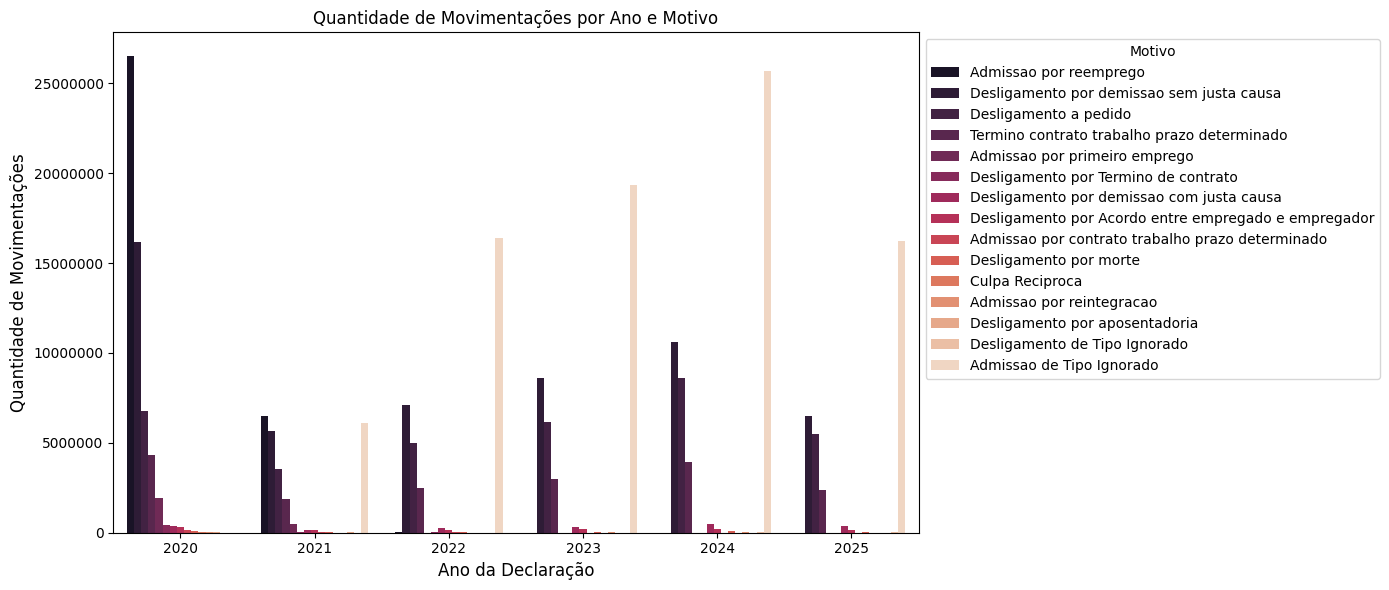

In [21]:
plt.figure(figsize=(14, 6))
g = sns.barplot(data=pandas_q1, x="ano_dec", y="qtd_mov", hue="descricao_motivo", palette="rocket")

plt.title("Quantidade de Movimentações por Ano e Motivo")

plt.xlabel("Ano da Declaração", fontsize=12)
plt.ylabel("Quantidade de Movimentações", fontsize=12)

ax = plt.gca()
formatter = ScalarFormatter()
formatter.set_scientific(False)
formatter.set_useOffset(False)
ax.yaxis.set_major_formatter(formatter)

g.legend_.set_bbox_to_anchor((1, 1))
g.legend_.set_title("Motivo")
plt.tight_layout()
plt.show()

## 2. Qual foi o principal motivo de movimentação em cada ano?

In [22]:
q2 = spark.sql("""
WITH ranked AS (
    SELECT
        f.ano_dec,
        m.descricao_motivo,
        COUNT(*) AS qtd_mov,
        ROW_NUMBER() OVER (PARTITION BY f.ano_dec ORDER BY COUNT(*) DESC) AS rn
    FROM fato_caged f
    LEFT JOIN dim_motivo m
        ON f.tipomovimentacao = m.tipomovimentacao
    GROUP BY f.ano_dec, m.descricao_motivo
)
SELECT ano_dec, descricao_motivo, qtd_mov
FROM ranked
WHERE rn = 1
ORDER BY ano_dec;
""")

In [23]:
q2.show()

+-------+--------------------+--------+
|ano_dec|    descricao_motivo| qtd_mov|
+-------+--------------------+--------+
|   NULL|                NULL|      10|
|   2020|Admissao por reem...|26503963|
|   2021|Admissao por reem...| 6467287|
|   2022|Admissao de Tipo ...|16363600|
|   2023|Admissao de Tipo ...|19319501|
|   2024|Admissao de Tipo ...|25660394|
|   2025|Admissao de Tipo ...|16251129|
+-------+--------------------+--------+



In [24]:
pandas_q2 = q2.toPandas()

In [25]:
pandas_q2.head()

,ano_dec,descricao_motivo,qtd_mov
0,NaN,None,10
1,2020.0,Admissao por reemprego,26503963
2,2021.0,Admissao por reemprego,6467287
3,2022.0,Admissao de Tipo Ignorado,16363600
4,2023.0,Admissao de Tipo Ignorado,19319501


In [26]:
pandas_q2.dropna(inplace=True)
pandas_q2["ano_dec"] = pandas_q2["ano_dec"].astype(int)


In [27]:
pandas_q2.head()

,ano_dec,descricao_motivo,qtd_mov
1,2020,Admissao por reemprego,26503963
2,2021,Admissao por reemprego,6467287
3,2022,Admissao de Tipo Ignorado,16363600
4,2023,Admissao de Tipo Ignorado,19319501
5,2024,Admissao de Tipo Ignorado,25660394


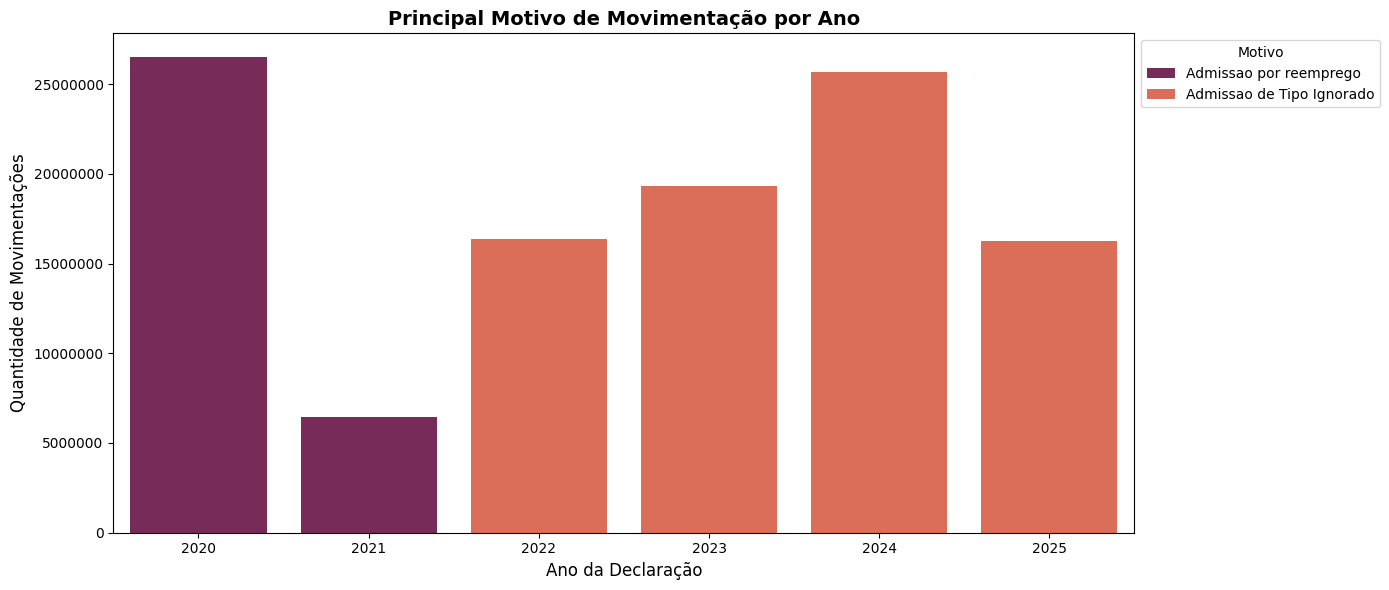

In [28]:
plt.figure(figsize=(14,6))

sns.barplot(
    data=pandas_q2,
    x="ano_dec",
    y="qtd_mov",
    hue="descricao_motivo",
    dodge=False,
    palette="rocket"
)

plt.xlabel("Ano da Declaração", fontsize=12)
plt.ylabel("Quantidade de Movimentações", fontsize=12)
plt.title("Principal Motivo de Movimentação por Ano", fontsize=14, fontweight="bold")


plt.legend(loc='upper left', bbox_to_anchor=(1,1), title="Motivo")

ax = plt.gca()
formatter = ScalarFormatter()
formatter.set_scientific(False)
formatter.set_useOffset(False)
ax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


## 3. Quais regiões geraram mais empregos ao longo do período analisado?

In [29]:
q3 = spark.sql("""
SELECT
    r.descricao_regiao,
    SUM(f.saldomovimentacao) AS saldo_emprego
FROM fato_caged f
LEFT JOIN dim_regiao r
    ON f.regiao = r.regiao
GROUP BY r.descricao_regiao
ORDER BY saldo_emprego DESC;
""")

In [30]:
q3.show()

+----------------+-------------+
|descricao_regiao|saldo_emprego|
+----------------+-------------+
|         Sudeste|      3018904|
|             Sul|      1346098|
|        Nordeste|      1227059|
|    Centro-Oeste|       777832|
|           Norte|       519793|
|            NULL|        28419|
|Nao identificado|        17756|
+----------------+-------------+



In [31]:
pandas_q3 = q3.toPandas()

In [32]:
pandas_q3.head()

,descricao_regiao,saldo_emprego
0,Sudeste,3018904
1,Sul,1346098
2,Nordeste,1227059
3,Centro-Oeste,777832
4,Norte,519793


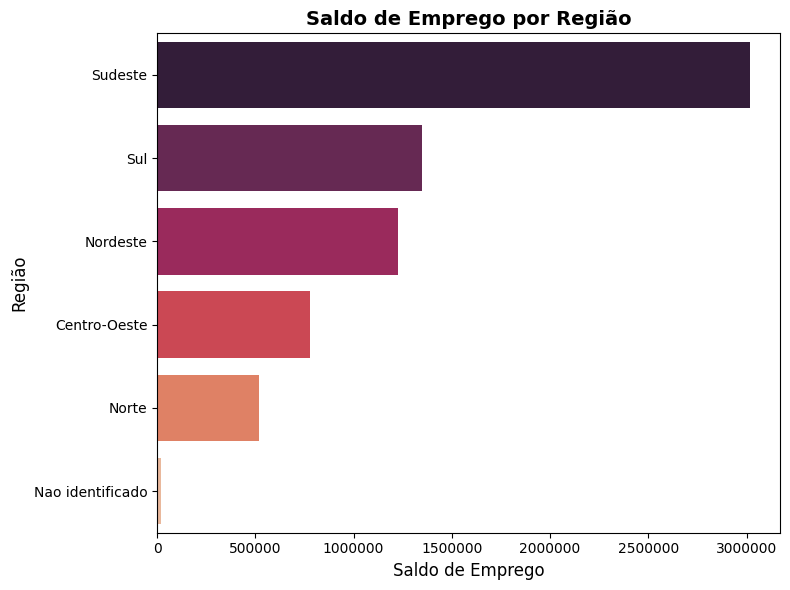

In [33]:
plt.figure(figsize=(8,6))

sns.barplot(
    data=pandas_q3,
    y="descricao_regiao",
    x="saldo_emprego",
    hue="descricao_regiao",
    palette="rocket"
)

plt.ylabel("Região", fontsize=12)
plt.xlabel("Saldo de Emprego", fontsize=12)
plt.title("Saldo de Emprego por Região", fontsize=14, fontweight="bold")

ax = plt.gca()
formatter = ScalarFormatter()
formatter.set_scientific(False)
formatter.set_useOffset(False)
ax.xaxis.set_major_formatter(formatter)

plt.legend().remove()

plt.tight_layout()
plt.show()


## 4. Em quais estados o saldo de empregos foi mais positivo ou negativo?

In [34]:
q4 = spark.sql("""
SELECT
    u.descricao_uf,
    SUM(f.saldomovimentacao) AS saldo_emprego
FROM fato_caged f
LEFT JOIN dim_uf u
    ON f.uf = u.uf
GROUP BY u.descricao_uf
ORDER BY saldo_emprego DESC;
""")

In [35]:
q4.show()

+-------------------+-------------+
|       descricao_uf|saldo_emprego|
+-------------------+-------------+
|          Sao Paulo|      1886798|
|       Minas Gerais|       697153|
|             Parana|       563080|
|     Santa Catarina|       511230|
|              Bahia|       352834|
|              Goias|       308573|
|     Rio de Janeiro|       275255|
|  Rio Grande do Sul|       271788|
|              Ceara|       217782|
|               Para|       215956|
|        Mato Grosso|       204040|
|         Pernambuco|       200780|
|     Espirito Santo|       159698|
|           Maranhao|       139082|
|   Distrito Federal|       135804|
| Mato Grosso do Sul|       129417|
|           Amazonas|       121107|
|Rio Grande do Norte|        86531|
|            Paraiba|        81427|
|            Alagoas|        57837|
+-------------------+-------------+
only showing top 20 rows



In [36]:
pandas_q4 = q4.toPandas()

In [37]:
pandas_q4.head()

,descricao_uf,saldo_emprego
0,Sao Paulo,1886798.0
1,Minas Gerais,697153.0
2,Parana,563080.0
3,Santa Catarina,511230.0
4,Bahia,352834.0


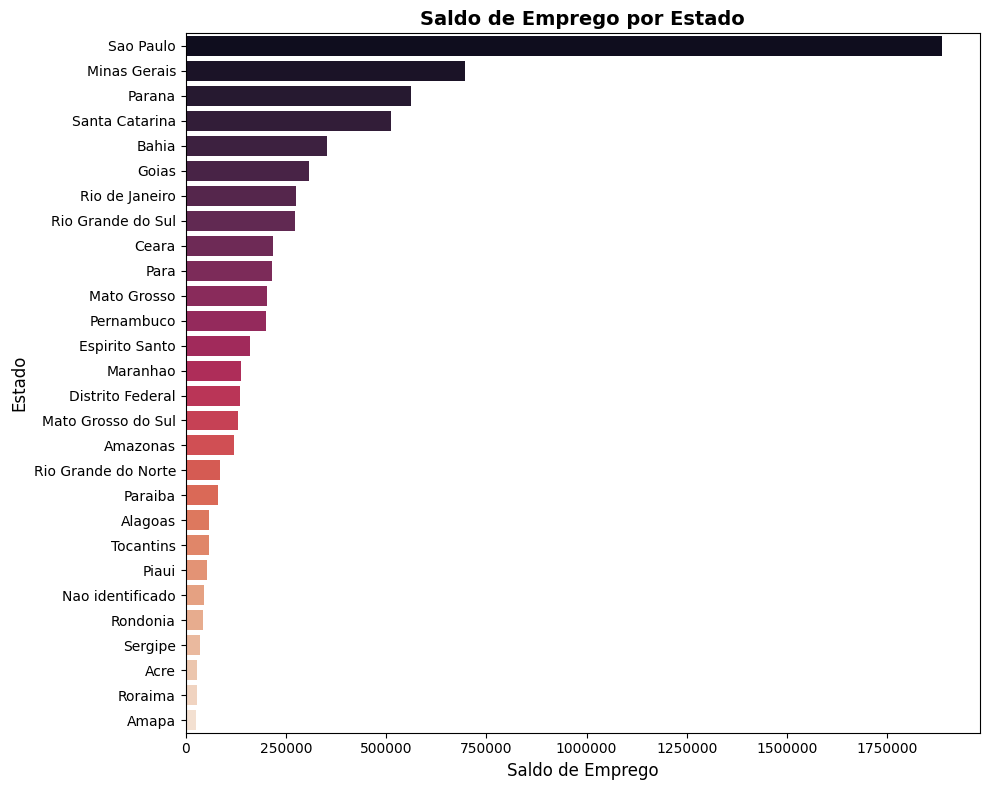

In [38]:
plt.figure(figsize=(10,8))

sns.barplot(
    data=pandas_q4,
    y="descricao_uf",
    x="saldo_emprego",
    hue="descricao_uf",
    palette="rocket"  )

plt.xlabel("Saldo de Emprego", fontsize=12)
plt.ylabel("Estado", fontsize=12)
plt.title("Saldo de Emprego por Estado", fontsize=14, fontweight="bold")

ax = plt.gca()
formatter = ScalarFormatter()
formatter.set_scientific(False)
formatter.set_useOffset(False)
ax.xaxis.set_major_formatter(formatter)

plt.legend().remove()

plt.tight_layout()
plt.show()


## 5. Existe alguma concentração de saldo de empregos em determinada região do país?

In [39]:
q5 = spark.sql("""
SELECT
    r.descricao_regiao,
    SUM(f.saldomovimentacao) AS saldo_regiao,
    ROUND(100.0 * SUM(f.saldomovimentacao) / SUM(SUM(f.saldomovimentacao)) OVER (), 2) AS perc_nacional
FROM fato_caged f
LEFT JOIN dim_regiao r
    ON f.regiao = r.regiao
GROUP BY r.descricao_regiao
ORDER BY perc_nacional DESC;
""")

In [40]:
q5.show()

+----------------+------------+-------------+
|descricao_regiao|saldo_regiao|perc_nacional|
+----------------+------------+-------------+
|         Sudeste|     3018904|        43.53|
|             Sul|     1346098|        19.41|
|        Nordeste|     1227059|        17.69|
|    Centro-Oeste|      777832|        11.21|
|           Norte|      519793|         7.49|
|            NULL|       28419|         0.41|
|Nao identificado|       17756|         0.26|
+----------------+------------+-------------+



In [41]:
pandas_q5 = q5.toPandas()

In [42]:
pandas_q5["descricao_regiao"] = pandas_q5["descricao_regiao"].fillna("Nao identificado")
pandas_q5["saldo_regiao"] = pandas_q5["saldo_regiao"].astype(int)
pandas_q5["perc_nacional"] = pandas_q5["perc_nacional"].astype(float)

In [43]:
pandas_q5 = pandas_q5.groupby("descricao_regiao", as_index=False).sum()
pandas_q5 = pandas_q5.sort_values("perc_nacional", ascending=False).reset_index(drop=True)

In [44]:
pandas_q5.head(10)

,descricao_regiao,saldo_regiao,perc_nacional
0,Sudeste,3018904,43.53
1,Sul,1346098,19.41
2,Nordeste,1227059,17.69
3,Centro-Oeste,777832,11.21
4,Norte,519793,7.49
5,Nao identificado,46175,0.67


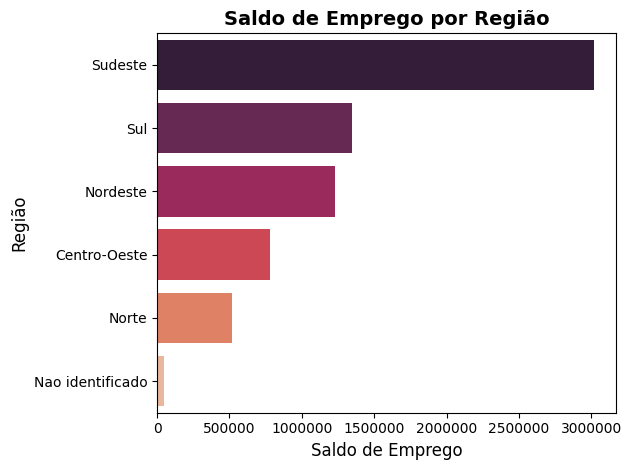

In [45]:
sns.barplot(
    data=pandas_q5,
    y="descricao_regiao",
    x="saldo_regiao",
    hue="descricao_regiao",
    palette="rocket"
)

plt.xlabel("Saldo de Emprego", fontsize=12)
plt.ylabel("Região", fontsize=12)
plt.title("Saldo de Emprego por Região", fontsize=14, fontweight="bold")

ax = plt.gca()
formatter = ScalarFormatter()
formatter.set_scientific(False)
formatter.set_useOffset(False)
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

## 6. Quais setores da economia mais contrataram ou desligaram trabalhadores em 2025?

In [46]:
q6 = spark.sql("""
SELECT
    s.descricao_secao,
    COUNT(*) AS qtd_mov
FROM fato_caged f
LEFT JOIN dim_secao s
    ON f.secao = s.secao
GROUP BY s.descricao_secao
ORDER BY qtd_mov DESC;
""")

In [47]:
q6.show()

+--------------------+--------+
|     descricao_secao| qtd_mov|
+--------------------+--------+
|Comercio, Reparac...|54662477|
|Atividades Admini...|39188020|
|Industrias de Tra...|34262772|
|          Construcao|22659013|
|Alojamento e Alim...|14082277|
|Transporte, Armaz...|12382976|
|Agricultura, Pecu...|12271339|
|Saude Humana e Se...|10735224|
|Atividades Profis...| 8029338|
|            Educacao| 6543656|
|Informacao e Comu...| 4584891|
|Outras Atividades...| 4516311|
|Atividades Financ...| 2297056|
|Artes, Cultura, E...| 1454803|
|Agua, Esgoto, Ati...| 1260484|
|Administracao Pub...| 1203584|
|Atividades Imobil...|  843204|
|Industrias Extrat...|  660975|
|  Eletricidade e Gas|  210553|
| Servicos Domesticos|   11929|
+--------------------+--------+
only showing top 20 rows



In [48]:
pandas_q6 = q6.toPandas()

In [49]:
pandas_q6.head()

,descricao_secao,qtd_mov
0,"Comercio, Reparacao de Veiculos Automotores e ...",54662477
1,Atividades Administrativas e Servicos Compleme...,39188020
2,Industrias de Transformacao,34262772
3,Construcao,22659013
4,Alojamento e Alimentacao,14082277


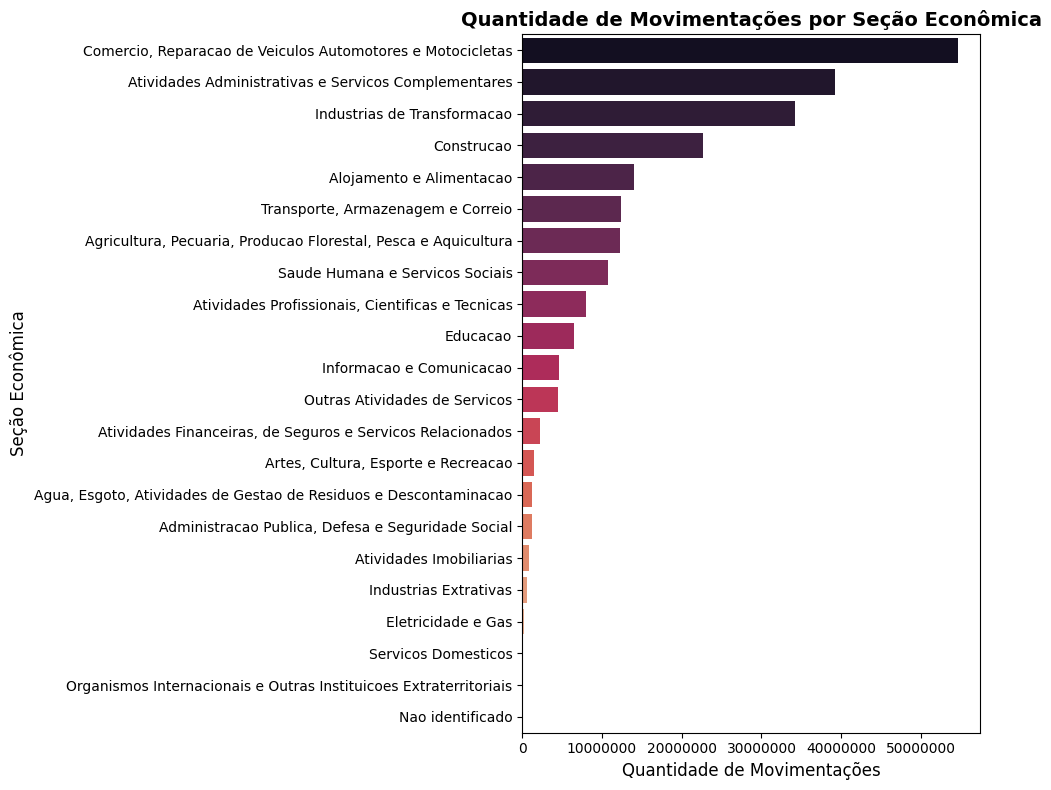

In [50]:
plt.figure(figsize=(10,8))

sns.barplot(
    data=pandas_q6,
    y="descricao_secao",
    x="qtd_mov",
    hue="descricao_secao",
    palette="rocket"
)

plt.xlabel("Quantidade de Movimentações", fontsize=12)
plt.ylabel("Seção Econômica", fontsize=12)
plt.title("Quantidade de Movimentações por Seção Econômica", fontsize=14, fontweight="bold")

ax = plt.gca()
formatter = ScalarFormatter()
formatter.set_scientific(False)
formatter.set_useOffset(False)
ax.xaxis.set_major_formatter(formatter)

plt.legend().remove()

plt.tight_layout()
plt.show()

## 7. Qual setor apresentou o maior saldo líquido de empregos?

In [51]:
q7 = spark.sql("""
SELECT
    s.descricao_secao,
    SUM(f.saldomovimentacao) AS saldo_emprego
FROM fato_caged f
LEFT JOIN dim_secao s
    ON f.secao = s.secao
GROUP BY s.descricao_secao
ORDER BY saldo_emprego DESC
LIMIT 1;
""")

In [52]:
q7.show()

+--------------------+-------------+
|     descricao_secao|saldo_emprego|
+--------------------+-------------+
|Atividades Admini...|      1283308|
+--------------------+-------------+



In [53]:
pandas_q7 = q7.toPandas()

In [54]:
print(f'O setor com o maior saldo líquido de empregos é o {pandas_q7['descricao_secao'][0]} com saldo de {pandas_q7['saldo_emprego'][0]} empregos no período analisado.')

O setor com o maior saldo líquido de empregos é o Atividades Administrativas e Servicos Complementares com saldo de 1283308 empregos no período analisado.


## 8. Há setores que consistentemente apresentam saldos negativos?

In [55]:
q8 = spark.sql("""
SELECT
    f.ano_dec,
    s.descricao_secao,
    SUM(f.saldomovimentacao) AS saldo_emprego
FROM fato_caged f
LEFT JOIN dim_secao s
    ON f.secao = s.secao
GROUP BY f.ano_dec, s.descricao_secao
HAVING SUM(f.saldomovimentacao) < 0
ORDER BY s.descricao_secao, f.ano_dec;
""")

In [56]:
q8.show()

+-------+--------------------+-------------+
|ano_dec|     descricao_secao|saldo_emprego|
+-------+--------------------+-------------+
|   2020|Alojamento e Alim...|      -577433|
|   2020|Artes, Cultura, E...|       -54745|
|   NULL|Atividades Admini...|           -1|
|   2020|Atividades Financ...|        -5381|
|   NULL|Comercio, Reparac...|           -2|
|   2020|Comercio, Reparac...|      -119138|
|   2020|            Educacao|      -109864|
|   2022|  Eletricidade e Gas|         -972|
|   NULL|Industrias de Tra...|           -1|
|   2020|    Nao identificado|           -4|
|   2021|    Nao identificado|           -3|
|   2022|    Nao identificado|           -3|
|   2023|    Nao identificado|          -12|
|   2020|Organismos Intern...|           -2|
|   2025|Organismos Intern...|          -63|
|   2020|Outras Atividades...|       -53736|
|   2020|Transporte, Armaz...|      -117394|
+-------+--------------------+-------------+



## 9. Qual é o nível de escolaridade predominante entre os admitidos?

In [58]:
q9 = spark.sql("""
SELECT
    g.descricao_instrucao,
    COUNT(*) AS qtd
FROM fato_caged f
LEFT JOIN dim_graudeinstrucao g
    ON f.graudeinstrucao = g.graudeinstrucao
WHERE f.tipomovimentacao IN (10, 20, 25, 35, 70, 97)
GROUP BY g.descricao_instrucao
ORDER BY qtd DESC
LIMIT 1;
""")

In [59]:
q9.show()

+-------------------+--------+
|descricao_instrucao|     qtd|
+-------------------+--------+
|     Medio Completo|75739475|
+-------------------+--------+



## 10. O perfil de escolaridade dos admitidos mudou ao longo dos anos?

In [60]:
q10 = spark.sql("""
SELECT
    f.ano_dec,
    g.descricao_instrucao,
    COUNT(*) AS qtd
FROM fato_caged f
LEFT JOIN dim_graudeinstrucao g
    ON f.graudeinstrucao = g.graudeinstrucao
WHERE f.tipomovimentacao IN (10, 20, 25, 35, 70, 97)
GROUP BY f.ano_dec, g.descricao_instrucao
ORDER BY f.ano_dec, qtd DESC;
""")

In [61]:
q10.show()

+-------+--------------------+--------+
|ano_dec| descricao_instrucao|     qtd|
+-------+--------------------+--------+
|   NULL|      Medio Completo|       2|
|   NULL| Superior Incompleto|       1|
|   2020|      Medio Completo|17410658|
|   2020|   Superior Completo| 2560720|
|   2020|Fundamental Completo| 2238012|
|   2020|    Medio Incompleto| 2175129|
|   2020| 6a a 9a Fundamental| 1401203|
|   2020| Superior Incompleto| 1186701|
|   2020|   Ate 5a Incompleto|  686248|
|   2020|5a Completo Funda...|  499893|
|   2020|Pos-Graduacao Com...|  240738|
|   2020|          Analfabeto|  128497|
|   2020|            Mestrado|   58410|
|   2020|           Doutorado|   21637|
|   2021|      Medio Completo| 8067744|
|   2021|   Superior Completo| 1192515|
|   2021|    Medio Incompleto| 1001403|
|   2021|Fundamental Completo|  973485|
|   2021| 6a a 9a Fundamental|  581150|
|   2021| Superior Incompleto|  549403|
+-------+--------------------+--------+
only showing top 20 rows



## 11. Trabalhadores com ensino superior têm participação relevante nas admissões?

In [62]:
q11 = spark.sql("""
SELECT
    f.ano_dec,
    CASE
        WHEN g.graudeinstrucao >= 9 THEN 'Nível Superior Completo ou acima'
        ELSE 'Até Nível Médio'
    END AS nivel,
    COUNT(*) AS qtd
FROM fato_caged f
LEFT JOIN dim_graudeinstrucao g
    ON f.graudeinstrucao = g.graudeinstrucao
WHERE f.tipomovimentacao IN (10, 20, 25, 35, 70, 97)
GROUP BY f.ano_dec,
    CASE
        WHEN g.graudeinstrucao >= 9 THEN 'Nível Superior Completo ou acima'
        ELSE 'Até Nível Médio'
    END
ORDER BY f.ano_dec, nivel;
""")

In [63]:
q11.show()

+-------+--------------------+--------+
|ano_dec|               nivel|     qtd|
+-------+--------------------+--------+
|   NULL|     Até Nível Médio|       3|
|   2020|     Até Nível Médio|25726341|
|   2020|Nível Superior Co...| 2881505|
|   2021|     Até Nível Médio|11704848|
|   2021|Nível Superior Co...| 1356817|
|   2022|     Até Nível Médio|14808319|
|   2022|Nível Superior Co...| 1646595|
|   2023|     Até Nível Médio|17537354|
|   2023|Nível Superior Co...| 1799197|
|   2024|     Até Nível Médio|23307182|
|   2024|Nível Superior Co...| 2370715|
|   2025|     Até Nível Médio|14737334|
|   2025|Nível Superior Co...| 1525132|
+-------+--------------------+--------+



## 12. Qual faixa etária concentra mais admissões?

In [64]:
q12 = spark.sql("""
SELECT
    f.faixa_etaria,
    COUNT(*) AS qtd_admissoes
FROM fato_caged f
WHERE f.tipomovimentacao IN (10, 20, 25, 35, 70, 97)
GROUP BY f.faixa_etaria
ORDER BY qtd_admissoes DESC
LIMIT 1;
""")

In [65]:
q12.show()

+------------+-------------+
|faixa_etaria|qtd_admissoes|
+------------+-------------+
|       25-34|     38596918|
+------------+-------------+



## 13. Qual faixa etária apresenta mais desligamentos a pedido?

In [66]:
q13 = spark.sql("""
SELECT
    f.faixa_etaria,
    COUNT(*) AS qtd_desligamentos
FROM fato_caged f
WHERE f.tipomovimentacao = 40
GROUP BY f.faixa_etaria
ORDER BY qtd_desligamentos DESC
LIMIT 1;
""")

In [67]:
q13.show()

+------------+-----------------+
|faixa_etaria|qtd_desligamentos|
+------------+-----------------+
|       25-34|         12449044|
+------------+-----------------+



## 14. Jovens (até 24 anos) são mais contratados em primeiro emprego ou em reemprego?

In [68]:
q14 = spark.sql("""
SELECT
    CASE
        WHEN f.tipomovimentacao = 10 THEN 'Primeiro emprego'
        WHEN f.tipomovimentacao = 20 THEN 'Reemprego'
    END AS tipo_admissao,
    COUNT(*) AS qtd
FROM fato_caged f
WHERE f.idade <= 24.0
  AND f.tipomovimentacao IN (10, 20)
GROUP BY
    CASE
        WHEN f.tipomovimentacao = 10 THEN 'Primeiro emprego'
        WHEN f.tipomovimentacao = 20 THEN 'Reemprego'
    END
ORDER BY qtd DESC;
""")

In [ ]:
q14.show()

## 15. Trabalhadores acima de 60 anos são desligados majoritariamente por aposentadoria ou por outros motivos?

In [72]:
q15 = spark.sql("""
SELECT
    CASE
        WHEN f.tipomovimentacao = 50 THEN 'Aposentadoria'
        ELSE 'Outros desligamentos'
    END AS tipo_desligamento,
    COUNT(*) AS qtd
FROM fato_caged f
WHERE f.idade >= 60.0
  AND f.tipomovimentacao IN (31, 32, 40, 43, 45, 50, 60, 80, 90, 98, 99)
GROUP BY
    CASE
        WHEN f.tipomovimentacao = 50 THEN 'Aposentadoria'
        ELSE 'Outros desligamentos'
    END
ORDER BY qtd DESC;
""")

In [ ]:
q15.show()

## 16. Quais ocupações mais geraram movimentações no período analisado (2020-2025)?

In [76]:
q16 = spark.sql("""
SELECT
    c.descricao_cbo,
    COUNT(*) AS qtd_mov
FROM fato_caged f
LEFT JOIN dim_cbo c
    ON f.cbo2002ocupacao = c.cbo
GROUP BY c.descricao_cbo
ORDER BY qtd_mov DESC
LIMIT 20;
""")

In [77]:
q16.show()

+--------------------+--------+
|       descricao_cbo| qtd_mov|
+--------------------+--------+
|Vendedor de Comer...|11984052|
|Alimentador de Li...|10714853|
|Faxineiro (Desati...|10622248|
|Auxiliar de Escri...| 8229424|
|   Servente de Obras| 7527142|
|Assistente Admini...| 6723210|
|   Operador de Caixa| 6325155|
|Motorista de Cami...| 5578578|
|Atendente de Loja...| 4853531|
|Repositor de Merc...| 4548335|
|Auxiliar nos Serv...| 3780975|
|Atendente de Lanc...| 3489110|
|Recepcionista, em...| 3268183|
|            Pedreiro| 3173278|
|Auxiliar de Logis...| 2683591|
|Operador de Telem...| 2668993|
|    Cozinheiro Geral| 2484498|
|          Almoxarife| 2339287|
|Porteiro de Edifi...| 2289245|
|Trabalhador Agrop...| 2283920|
+--------------------+--------+



## 17. Quais cargos mais contribuíram para o saldo positivo de empregos?

In [78]:
q17 = spark.sql("""
SELECT
    c.descricao_cbo,
    SUM(f.saldomovimentacao) AS saldo_emprego
FROM fato_caged f
LEFT JOIN dim_cbo c
    ON f.cbo2002ocupacao = c.cbo
GROUP BY c.descricao_cbo
ORDER BY saldo_emprego DESC
LIMIT 20;
""")

In [79]:
q17.show()

+--------------------+-------------+
|       descricao_cbo|saldo_emprego|
+--------------------+-------------+
|Alimentador de Li...|      1004609|
|Faxineiro (Desati...|       559486|
|   Servente de Obras|       504572|
|Atendente de Loja...|       318923|
|Assistente Admini...|       318736|
|Auxiliar de Escri...|       296566|
|Auxiliar de Logis...|       272059|
|Tecnico de Enferm...|       221245|
|Repositor de Merc...|       216113|
|Motorista de Cami...|       205672|
|Recepcionista, em...|       158483|
|Auxiliar nos Serv...|       146471|
|    Embalador, a Mao|       138056|
|   Operador de Caixa|       130945|
|Ajudante de Motor...|       123933|
|         Armazenista|       120288|
|Trabalhador Volan...|        97737|
|          Enfermeiro|        95642|
|          Estoquista|        91605|
|          Almoxarife|        85841|
+--------------------+-------------+



## 18. Existem ocupações com grande volume de admissões mas também alto volume de desligamentos?

In [74]:
q18 = spark.sql("""
SELECT
    c.descricao_cbo,
    SUM(CASE WHEN f.saldomovimentacao = 1  THEN 1 ELSE 0 END) AS qtd_admissoes,
    SUM(CASE WHEN f.saldomovimentacao = -1 THEN 1 ELSE 0 END) AS qtd_desligamentos
FROM fato_caged f
LEFT JOIN dim_cbo c
    ON f.cbo2002ocupacao = c.cbo
GROUP BY c.descricao_cbo
HAVING SUM(CASE WHEN f.saldomovimentacao = 1  THEN 1 ELSE 0 END) > 50000
   AND SUM(CASE WHEN f.saldomovimentacao = -1 THEN 1 ELSE 0 END) > 50000
ORDER BY qtd_admissoes DESC, qtd_desligamentos DESC
LIMIT 20;
""")

In [75]:
q18.show()

+--------------------+-------------+-----------------+
|       descricao_cbo|qtd_admissoes|qtd_desligamentos|
+--------------------+-------------+-----------------+
|Vendedor de Comer...|      5954146|          6029906|
|Alimentador de Li...|      5859731|          4855122|
|Faxineiro (Desati...|      5590867|          5031381|
|Auxiliar de Escri...|      4262995|          3966429|
|   Servente de Obras|      4015857|          3511285|
|Assistente Admini...|      3520973|          3202237|
|   Operador de Caixa|      3228050|          3097105|
|Motorista de Cami...|      2892125|          2686453|
|Atendente de Loja...|      2586227|          2267304|
|Repositor de Merc...|      2382224|          2166111|
|Auxiliar nos Serv...|      1963723|          1817252|
|Atendente de Lanc...|      1759048|          1730062|
|Recepcionista, em...|      1713333|          1554850|
|            Pedreiro|      1618005|          1555273|
|Auxiliar de Logis...|      1477825|          1205766|
|Operador 